In [1]:
# Import machine learning and dataset modules
import torch
import tarfile
import os

import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# Enable PyTorch to use CUDA cores if they are avialable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
batch_size = 4

In [4]:
class ToFractionTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        inputs, targets = sample
        s = inputs[0].sum()
        
        inputs = np.divide(inputs, s)
        
        inputs[inputs < 0] = -1
        
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [9]:
# Implement custom dataset loader for synthetic data
class SyntheticDataset(Dataset):
    def __init__(self, tar_path='datasets/synthetic-16:43:49.tar.gz', transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        
        with tarfile.open(tar_path) as tar:
            for member in tar.getmembers():
                if member.isfile():
                    f = tar.extractfile(member)
                    fn = member.name
                    bn = os.path.basename(fn)
                    uuid = os.path.basename(Path(fn).parent.parent) + os.path.basename(Path(fn).parent)
                    df = pd.read_csv(f)
                    
                    # If filename is features.csv, append to y tensor
                    if 'features.csv' in bn:
                        df['network_name'] = [os.path.splitext(name)[0] for name in df['network_name']]
                        df.drop(['population', 'backend'], axis=1, inplace=True)
                        self.y.append(df)
                        
                    # If filename is timeseries.csv, append to X tensor
                    if 'timeseries.csv' in bn:
                        df['uuid'] = uuid
                        self.X.append(df)
        
        self.y = pd.concat(self.y)
        self.X = pd.concat(self.X)
        
        self.network_mapping = {k: v for v, k in enumerate(self.y['network_name'].unique())}
        self.y['network_type'] = self.y['network_name'].map(self.network_mapping)
        
        self.y_data = self.y.drop(['network_name'], axis=1).to_numpy(dtype=np.float64)
        
        # Stackoverflow magic
        g = self.X.groupby('uuid').cumcount()
        self.X_data = (self.X.set_index(['uuid', g])
            .unstack(fill_value=-1).stack()
            .groupby(level=0)
            .apply(lambda x: x.values.tolist())
            .tolist())
        
        self.X_data = np.array(self.X_data, dtype=np.int)
    
    def __getitem__(self, index):
        sample = self.X_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
    def __len__(self):
        return len(self.y)

In [10]:
# Design the convolutional neural network model to determine network_type
class ConvnetNetworkClassifier(nn.Module):
    def __init__(self, n_input_features=500, n_output_features=1):
        super(ConvnetNetworkClassifier, self).__init__()
        self.n_input_features = n_input_features
        self.n_output_features = n_output_features
    
    def forward(self, X):
        pass

    def shape(self):
        return self.n_input_features, self.n_output_features

In [67]:
def plot_timeseries(ts):
    ts = pd.DataFrame(ts[~np.all(ts == -1, axis=1)],
                      columns=['susceptible', 'infected', 'recovered', 'dead'])
    ts = pd.DataFrame(ts, columns=['susceptible', 'infected', 'recovered', 'dead'])
    ts.plot()
    plt.xlabel('days')
    plt.ylabel('fraction')
    plt.show()

In [65]:
# Split up training, validation, and testing dataset
whole_set = SyntheticDataset(transform=ToFractionTensor())

l = len(whole_set)

# training = 50%, validation = 20%, testing = 30%
n_val = int(0.2*l)
n_test = int(0.3*l)
n_train = l - n_test - n_val

train_set, val_set, test_set = random_split(whole_set, [n_train, n_val, n_test])

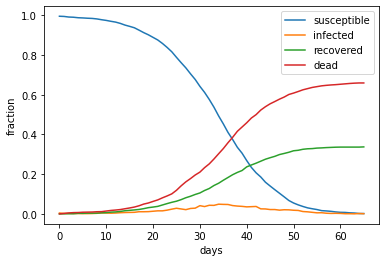

(initial_infected            9
 network_name        WS-6-2000
 infectiousness       0.043908
 i_out                0.682962
 i_rec_prop           0.666092
 Name: 0, dtype: object,
 (501, 4),
 array([[9.955e-01, 4.500e-03, 0.000e+00, 0.000e+00],
        [9.945e-01, 2.500e-03, 5.000e-04, 2.500e-03],
        [9.915e-01, 2.500e-03, 1.000e-03, 5.000e-03],
        [9.905e-01, 2.000e-03, 1.000e-03, 6.500e-03],
        [9.880e-01, 2.000e-03, 3.000e-03, 7.000e-03],
        [9.870e-01, 1.500e-03, 3.000e-03, 8.500e-03],
        [9.855e-01, 1.500e-03, 4.000e-03, 9.000e-03],
        [9.845e-01, 2.000e-03, 4.000e-03, 9.500e-03],
        [9.820e-01, 3.000e-03, 4.000e-03, 1.100e-02],
        [9.780e-01, 5.000e-03, 5.500e-03, 1.150e-02],
        [9.745e-01, 4.500e-03, 6.500e-03, 1.450e-02],
        [9.700e-01, 3.500e-03, 9.000e-03, 1.750e-02],
        [9.660e-01, 4.500e-03, 1.000e-02, 1.950e-02],
        [9.595e-01, 6.000e-03, 1.250e-02, 2.200e-02],
        [9.510e-01, 7.000e-03, 1.600e-02, 2.600e-02],

In [91]:
# Dataset number
DSN = 2136

# Plot data for sanity
plot_timeseries(whole_set[DSN][0].numpy())

# Print out parameters
ts = whole_set[DSN][0].numpy()
whole_set.y.iloc[DSN, :-1], whole_set.X_data.shape[1:], ts[~np.all(ts == -1, axis=1)]

In [406]:
# Setup data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_set = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [407]:
# Number of input and output features
n_input_features = whole_set.X_data.shape[1]
n_output_features = len(whole_set.network_mapping)

# Create convolutional multiclassifier for network type
model = ConvnetNetworkClassifier(n_input_features=n_input_features,
                                 n_output_features=n_output_features).to(device)

model.shape()

(500, 28)